![image](https://github.com/eWaterCycle/ewatercycle/raw/main/docs/examples/logo.png)

# Running Wflow using the ewatercycle system

// TODO add intro and link to system setup


In [1]:
import ewatercycle.models
import ewatercycle.parameter_sets

/home/verhoes/miniconda39/envs/ewatercycle/lib/python3.9/site-packages/esmvalcore/experimental/_warnings.py:18: UserWarning: 
  Thank you for trying out the new ESMValCore API.
  Note that this API is experimental and may be subject to change.
  More info: https://github.com/ESMValGroup/ESMValCore/issues/498
/home/verhoes/miniconda39/envs/ewatercycle/lib/python3.9/site-packages/esmvalcore/experimental/config/_config_validators.py:254: ESMValToolDeprecationWarning: `write_plots` will be removed in 2.4.0.
/home/verhoes/miniconda39/envs/ewatercycle/lib/python3.9/site-packages/esmvalcore/experimental/config/_config_validators.py:255: ESMValToolDeprecationWarning: `write_netcdf` will be removed in 2.4.0.


## Setting up the model

The model needs a parameter set and forcing. The parameter set can be gotten from the available parameters sets on the system and the forcing can derived from the parameter set.

In [2]:
parameter_set = ewatercycle.parameter_sets.get_parameter_set('wflow_rhine_sbm_nc')
print(parameter_set)

Parameter set
-------------
name=wflow_rhine_sbm_nc
directory=/home/verhoes/git/eWaterCycle/ewatercycle/docs/examples/parameter-sets/wflow_rhine_sbm_nc
config=/home/verhoes/git/eWaterCycle/ewatercycle/docs/examples/parameter-sets/wflow_rhine_sbm_nc/wflow_sbm_NC.ini
doi=N/A
target_model=wflow
supported_model_versions={'2020.1.1'}


In [4]:
forcing = ewatercycle.forcing.load_foreign(
    directory = parameter_set.directory,
    target_model = 'wflow',
    start_time = '1991-01-01T00:00:00Z',
    end_time = '1991-12-31T00:00:00Z',
    forcing_info = dict(
        # Additional information about the external forcing data needed for the model configuration
        netcdfinput = "inmaps.nc",
        Precipitation = "/P",
        EvapoTranspiration = "/PET",
        Temperature = "/TEMP"
    )
)
print(forcing)

Forcing data for Wflow
----------------------
Directory: /home/verhoes/git/eWaterCycle/ewatercycle/docs/examples/parameter-sets/wflow_rhine_sbm_nc
Start time: 1991-01-01T00:00:00Z
End time: 1991-12-31T00:00:00Z
Shapefile: None
Additional information for model config:
  - netcdfinput: inmaps.nc
  - Precipitation: /P
  - Temperature: /TEMP
  - EvapoTranspiration: /PET
  - Inflow: None


Pick a version of Wflow model, so the right model code can be executed which understands the parameter set and forcing.

In [6]:
ewatercycle.models.Wflow.available_versions

('2020.1.1',)

In [7]:
# Create the model instance
model = ewatercycle.models.Wflow(version='2020.1.1', parameter_set=parameter_set, forcing=forcing)

In [8]:
# inspect the pre-configured parameters
model.parameters

[('start_time', '1991-01-01T00:00:00Z'), ('end_time', '1991-12-31T00:00:00Z')]

In [9]:
# Set up the model; this is where you can potentially overwrite some of the parameters
cfg_file, cfg_dir = model.setup(end_time = "1991-02-28T00:00:00Z")

In [10]:
# See the run directory and model configuration file
print(cfg_file)
print(cfg_dir)

/home/verhoes/git/eWaterCycle/ewatercycle/docs/examples/output/wflow_20210712_133537/wflow_ewatercycle.ini
/home/verhoes/git/eWaterCycle/ewatercycle/docs/examples/output/wflow_20210712_133537


### Update the config file

At this point, we have a preliminary configuration file (`cfg_file`). You can open it and modify. For the example below, you will have to add the variable "RiverRunoff" to the API section:

```
[API]
RiverRunoff = 2, m/s
```

After that, we can start up the model

In [11]:
model.initialize(cfg_file)

## Running the model

In [12]:
# Inspect the initial values for RiverRunoff
model.get_value("RiverRunoff")  # WFlow interally uses a fill-value for masked data of -999

array([-999., -999., -999., ..., -999., -999., -999.])

In [13]:
# You can also view get the data as xarray data-array
model.get_value_as_xarray("RiverRunoff")  # this automatically converts the -999 values to NaN

<xarray.DataArray 'RiverRunoff' (latitude: 169, longitude: 187)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * longitude  (longitude) float64 5.227 5.264 5.3 5.337 ... 11.97 12.01 12.05
  * latitude   (latitude) float64 45.89 45.93 45.97 46.0 ... 51.98 52.02 52.05
    time       object 1990-12-31 00:00:00
Attributes:
    units:     m/s

In [14]:
# Run the model until complete
while model.time < model.end_time:
    print(model.time_as_isostr)
    model.update()

1990-12-31T00:00:00Z
1991-01-01T00:00:00Z
1991-01-02T00:00:00Z
1991-01-03T00:00:00Z
1991-01-04T00:00:00Z
1991-01-05T00:00:00Z
1991-01-06T00:00:00Z
1991-01-07T00:00:00Z
1991-01-08T00:00:00Z
1991-01-09T00:00:00Z
1991-01-10T00:00:00Z
1991-01-11T00:00:00Z
1991-01-12T00:00:00Z
1991-01-13T00:00:00Z
1991-01-14T00:00:00Z
1991-01-15T00:00:00Z
1991-01-16T00:00:00Z
1991-01-17T00:00:00Z
1991-01-18T00:00:00Z
1991-01-19T00:00:00Z
1991-01-20T00:00:00Z
1991-01-21T00:00:00Z
1991-01-22T00:00:00Z
1991-01-23T00:00:00Z
1991-01-24T00:00:00Z
1991-01-25T00:00:00Z
1991-01-26T00:00:00Z
1991-01-27T00:00:00Z
1991-01-28T00:00:00Z
1991-01-29T00:00:00Z
1991-01-30T00:00:00Z
1991-01-31T00:00:00Z
1991-02-01T00:00:00Z
1991-02-02T00:00:00Z
1991-02-03T00:00:00Z
1991-02-04T00:00:00Z
1991-02-05T00:00:00Z
1991-02-06T00:00:00Z
1991-02-07T00:00:00Z
1991-02-08T00:00:00Z
1991-02-09T00:00:00Z
1991-02-10T00:00:00Z
1991-02-11T00:00:00Z
1991-02-12T00:00:00Z
1991-02-13T00:00:00Z
1991-02-14T00:00:00Z
1991-02-15T00:00:00Z
1991-02-16T00

array([200.80599976,  44.62182236,   0.        ])

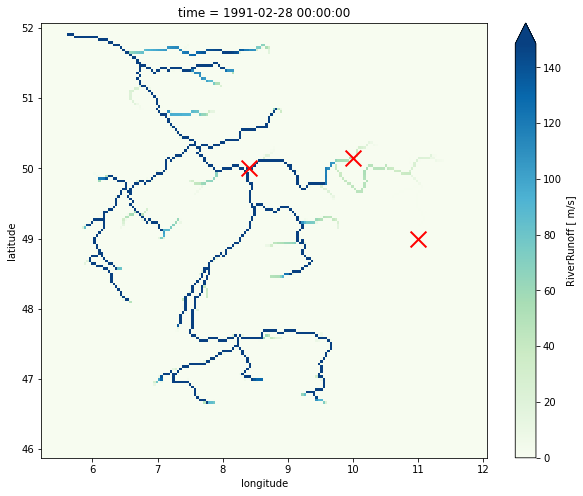

In [15]:
# Get the final output and create a simple plot
da = model.get_value_as_xarray("RiverRunoff")
qm = da.plot(robust=True, cmap='GnBu', figsize=(10, 8))

# Add some crosses to check that 'get_value_at_coords' works correctly below
qm.axes.scatter([8.4, 10, 11], [50, 50.15, 49], s=250, c='r', marker='x', lw=2)
model.get_value_at_coords('RiverRunoff', lon=[8.4, 10, 11,], lat=[50, 50.15, 49])

In [16]:
# Cleaning up
model.finalize()